# Bayes Opt for Tendons

 - Tendon Generator with compsol 
 - Link bayesian with shores (geometry later)
 - Define cost function as stored energy (for now, transient solutions later)

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np 
from bayes_opt import BayesianOptimization 
import scipy as sp 
import mph 
import pandas as pd
from bayes_opt import UtilityFunction
from stl import mesh
from bayes_opt.event import DEFAULT_EVENTS, Events
from tendon_Graphs import hex_to_RGB,RGB_to_hex,color_dict,linear_gradient,find_nearest,graph_tendon,compare_coarse

# Functions

In [8]:

#------------------------------------------------------------------------------------
## Utilites

def score_plot(out):
    fig, ax = plt.subplots()
    scores = np.zeros((31,1))
    for i in range(1,len(out)):
        scores[i] = out[i]['target']
    ax.scatter(np.linspace(1,31,31),scores)
    fig.suptitle('Bayes Results')
    fig.savefig( 'Bayes Results.png')

# Shore Coefficient equations from experimental fit
def s_c1(s):
    return 4.905e20*np.exp(-2.256*s) + 2.893e6*np.exp(-0.04024*s)

def s_c2(s):
    return -5.529e8*np.exp(-0.4783*s) + 384.7*np.exp(0.0967*s)

def s_c3(s):
    return 18.3*s**2 - 1744*s + 4.23e4
  
## SIMULATION WITH GEOMETRY/MATERIAL SETUP COMSOL PARTS
def geom3d_generator(r1,r2,L,t1,t2):
    
    X = np.linspace(L/10,L,10)
    x = X*10
    r = 0.01*(1-x)**3 + r1*3*x*(1-x)**2 + r2*3*x**2*(1-x) + 0.01*x**3
    t = 0.0025*(1-x)**3 + t1*3*x*(1-x)**2 + t2*3*x**2*(1-x) + 0.0025*x**3


    for ii in range (0,9):
        
        # Define the 8 vertices of the Block
        vertices = np.array([\
            [-r[ii+1], -t[ii+1], 0.01+ii*0.01],
            [+r[ii+1], -t[ii+1], 0.01+ii*0.01],
            [+r[ii+1], +t[ii+1], 0.01+ii*0.01],
            [-r[ii+1], +t[ii+1], 0.01+ii*0.01],
            [-r[ii], -t[ii], 0+ii*0.01],
            [+r[ii], -t[ii], 0+ii*0.01],
            [+r[ii], +t[ii], 0+ii*0.01],
            [-r[ii], +t[ii], 0+ii*0.01]])
        # Define the 12 triangles composing the cube
        faces = np.array([\
            [0,3,1],
            [1,3,2],
            [0,4,7],
            [0,7,3],
            [4,5,6],
            [4,6,7],
            [5,1,2],
            [5,2,6],
            [2,3,6],
            [3,7,6],
            [0,1,5],
            [0,5,4]])

        # Create the mesh
        cube = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
        for i, f in enumerate(faces):
            for j in range(3):
                cube.vectors[i][j] = vertices[f[j],:]

        # Write the mesh to file "cube.stl"
        # File name is based on which block it
        filename = str(ii+1) + "B.stl"
        print(ii+1)
        print(filename)
        cube.save(filename)
        
class BasicObserver:
    def update(self, event, instance):
        """Updates counter for saving"""
        global count
        count += 1
        print(count)
        
#------------------------------------------------------------------------------------
## Sim Functions

def Sim2D_SRL(s1,s2,s3,s4,r1,r2,L): # Unfortunately have to update each time I change iii
    """ 
    Evaluates the energetic efficiency
    Can possibly expand this to force modulation by comparing Force-Velocity of PH and tendon
    For now, for a given PH, this will  evaluate energy storage. No need to model efficiency of 
    PH energy storage as a bigger energy -> Better efficiency  
    """
    # !!! Should clear stored solution so new one can be added || also wipes mesh
    model.clear()
    
    # Dictionary of Shore- Yeoh Coeffs realtions
    coeff_eqns = {'c1': s_c1, 'c2': s_c2, 'c3': s_c3}   

    x = np.linspace(0,1,10)
    
    
    
    S = s1*(1-x)**3 + s2*3*x*(1-x)**2 + s3*3*x**2*(1-x) + s4*x**3
    radius = 0.01*(1-x)**3 + r1*3*x*(1-x)**2 + r2*3*x**2*(1-x) + 0.01*x**3
    params = [s1, s2 , s3, s4 ,r1,r2,L]
    steps = 10
    file = 'Iteration' + str(count)
    compare_coarse(params,steps,file)
    # fig, ax = plt.subplots()
    # ax.plot(X,S)
    # fig, ax = plt.subplots()
    # ax.plot(X,radius)
    ## Build 
    # Set mesh parts to different coefficients based on shore hardness
    # print(radius*1000)
    # print(S)
    for j in range(1,n+1): #for each block
        # print(j)
        if j < n:
            model.parameter('r'+str(j), radius[j-1]) # RADIUS UPDATE
            # print('r' + str(j) + "=" + str(radius[j-1]))
            # print('S =' + str(S[j-1]))
        for i in range(1,4): #for each yeoh coefficient
            
            # print('c' + str(j) +  str(i) + "=" + str(coeff_eqns["c" + str(i)](S[j-1])))
            model.parameter('c' + str(j) +  str(i),coeff_eqns["c" + str(i)](S[j-1])) # update it based on dictionary of shore - yeoh equations
    
    model.parameter('l',L) # Update Length
   
    # Do Sim 
    model.build()
    model.mesh()
    model.save("Bayes_Attempt") # Save attempt for reference in errors
    try:
        model.solve('PreLoad') # SOLVE
        model.save("Bayes_Solved") # IF solution succesful, save solution
        #Pull relevant data
        model.export() # All export will give useful files and videos
        
        
        ## Here is the data stuff. Pull from Panda and convery to np.
        # only using 1d sub arrays so thats done here too
        
        data = pd.read_csv('results.csv')
        data.to_csv('Bayes_slr ' + str(count))
        data = data.to_numpy()
        dataF = data[:,1]
        datax = data[:,2]
        time = data[:,0]
        dataE = data[:,3]

    
        ## BELOW IS ANALYTICAL MODEL COMPARISON
        # Fph,Xph = PH()
        # break_idx = PH_Experimental(datax,dataF)
        SEE_eng =  np.max(dataE)  # optimal  value
        
    except:
        print("Solver issure")
        model.save("Bayes_error") # IF solution succesful, save solution
        SEE_eng =0
    print(SEE_eng)
    
    # fig,ax = plt.subplots()
    # ax.plot(time,dataE)
    
    ## Seek Blockpoint of SEE/PH interaction for optimal energy storage value
    
    
    
    ## plot if you like
    # fig, ax = plt.subplots() 
    # ax.plot(Xph,Fph)
    # ax2 = ax.twinx() 
    # ax2.plot(datax,dataE)

    
    return SEE_eng # returns Energy value to optimsie

def Sim2D_SR(s1,s2,s3,s4,r1,r2): # Unfortunately have to update each time I change iii
    """ 
    Evaluates the energetic efficiency
    Can possibly expand this to force modulation by comparing Force-Velocity of PH and tendon
    For now, for a given PH, this will  evaluate energy storage. No need to model efficiency of 
    PH energy storage as a bigger energy -> Better efficiency  
    """
    # !!! Should clear stored solution so new one can be added || also wipes mesh
    model.clear()
    
    # Dictionary of Shore- Yeoh Coeffs realtions
    coeff_eqns = {'c1': s_c1, 'c2': s_c2, 'c3': s_c3}   

    X = np.linspace(0.01,0.1,10)
    
    
    x = X*10
    S = s1*(1-x)**3 + s2*3*x*(1-x)**2 + s3*3*x**2*(1-x) + s4*x**3
    radius = 0.01*(1-x)**3 + r1*3*x*(1-x)**2 + r2*3*x**2*(1-x) + 0.01*x**3
    # fig, ax = plt.subplots()
    # ax.plot(X,S)
    # fig, ax = plt.subplots()
    # ax.plot(X,radius)
    ## Build 
    # Set mesh parts to different coefficients based on shore hardness
    print(radius*1000)
    print(S)
    for j in range(1,n+1): #for each block
        # print(j)
        if j < n:
            model.parameter('r'+str(j), radius[j-1]) # RADIUS UPDATE
            # print('r' + str(j) + "=" + str(radius[j-1]))
            # print('S =' + str(S[j-1]))
        for i in range(1,4): #for each yeoh coefficient
            
            # print('c' + str(j) +  str(i) + "=" + str(coeff_eqns["c" + str(i)](S[j-1])))
            model.parameter('c' + str(j) +  str(i),coeff_eqns["c" + str(i)](S[j-1])) # update it based on dictionary of shore - yeoh equations
    ''''''
    '''
    # Radius updates
    # '''
    # for i in range(1,n):
        
    # Do Sim 
    model.build()
    model.mesh()
    model.save("Bayes_Attempt") # Save attempt for reference in errors
    try:
        model.solve('PreLoad') # SOLVE
        model.save("Bayes_Solved") # IF solution succesful, save solution
        #Pull relevant data
        model.export() # All export will give useful files and videos
        
        
        ## Here is the data stuff. Pull from Panda and convery to np.
        # only using 1d sub arrays so thats done here too
        
        data = pd.read_csv('results.csv')
        data.to_csv('Bayes_sr ' + str(count))
        data = data.to_numpy()
        dataF = data[:,1]
        datax = data[:,2]
        time = data[:,0]
        dataE = data[:,3]

    
        ## BELOW IS ANALYTICAL MODEL COMPARISON
        
        
        ## Seek Blockpoint of SEE/PH interaction for optimal energy storage value
        
        # Fph,Xph = PH()
        
        # fig, ax = plt.subplots() 
        # ax.plot(Xph,Fph)
        # ax2 = ax.twinx() 
        # ax2.plot(datax,dataE)

        break_idx = PH_Experimental(datax,dataF)
        SEE_eng =  dataE[break_idx]  # optimal  value
        print(break_idx)
    except:
        print("Solver issure")
        model.save("Bayes_error") # IF solution succesful, save solution
        SEE_eng =0
    
    print(SEE_eng)
    
    # fig,ax = plt.subplots()
    # ax.plot(time,dataE)
    return SEE_eng # returns Energy value to optimsier 

def Sim2D_S(s1,s2,s3,s4): # Unfortunately have to update each time I change iii
    """ 
    Evaluates the energetic efficiency
    Can possibly expand this to force modulation by comparing Force-Velocity of PH and tendon
    For now, for a given PH, this will  evaluate energy storage. No need to model efficiency of 
    PH energy storage as a bigger energy -> Better efficiency  
    """
    # !!! Should clear stored solution so new one can be added || also wipes mesh
    model.clear()
    
    # Dictionary of Shore- Yeoh Coeffs realtions
    coeff_eqns = {'c1': s_c1, 'c2': s_c2, 'c3': s_c3}   

    X = np.linspace(0.01,0.1,10)
    
    
    x = X*10
    S = s1*(1-x)**3 + s2*3*x*(1-x)**2 + s3*3*x**2*(1-x) + s4*x**3
    radius = 0.01*X
    # fig, ax = plt.subplots()
    # ax.plot(X,S)
    # fig, ax = plt.subplots()
    # ax.plot(X,radius)
    ## Build 
    # Set mesh parts to different coefficients based on shore hardness
    print(radius*1000)
    print(S)
    for j in range(1,n+1): #for each block
        print(j)
        if j < n:
            model.parameter('r'+str(j), radius[j-1]) # RADIUS UPDATE
            print('r' + str(j) + "=" + str(radius[j-1]))
            print('S =' + str(S[j-1]))
        for i in range(1,4): #for each yeoh coefficient
            
            print('c' + str(j) +  str(i) + "=" + str(coeff_eqns["c" + str(i)](S[j-1])))
            model.parameter('c' + str(j) +  str(i),coeff_eqns["c" + str(i)](S[j-1])) # update it based on dictionary of shore - yeoh equations
    ''''''
    '''
    # Radius updates
    # '''
    # for i in range(1,n):
        
    # Do Sim 
    model.build()
    model.mesh()
    model.save("Bayes_Attempt") # Save attempt for reference in errors
    model.solve('PreLoad') # SOLVE
    model.save("Bayes_Solved") # IF solution succesful, save solution
    #Pull relevant data
    model.export() # All export will give useful files and videos
    
    
    ## Here is the data stuff. Pull from Panda and convery to np.
    # only using 1d sub arrays so thats done here too
    
    
    

   
    ## BELOW IS ANALYTICAL MODEL COMPARISON
    
    
    ## Seek Blockpoint of SEE/PH interaction for optimal energy storage value
    
    Fph,Xph = PH()
    
    # fig, ax = plt.subplots() 
    # ax.plot(Xph,Fph)
    # ax2 = ax.twinx() 
    # ax2.plot(datax,dataE)

    break_idx = breakpoint(datax,-dataF,Xph,Fph)
    SEE_eng =  dataE[break_idx]  # optimal  value
    print(break_idx)
    print(SEE_eng)
    print(datax[break_idx])
    # fig,ax = plt.subplots()
    # ax.plot(time,dataE)
    return SEE_eng # returns Energy value to optimsier 

def Sim2D_R(r1,r2): # Unfortunately have to update each time I change iii
    """ 
    Evaluates the energetic efficiency
    Can possibly expand this to force modulation by comparing Force-Velocity of PH and tendon
    For now, for a given PH, this will  evaluate energy storage. No need to model efficiency of 
    PH energy storage as a bigger energy -> Better efficiency  
    """
    # !!! Should clear stored solution so new one can be added || also wipes mesh
    model.clear()
    
    # Dictionary of Shore- Yeoh Coeffs realtions
    coeff_eqns = {'c1': s_c1, 'c2': s_c2, 'c3': s_c3}   

    X = np.linspace(0.01,0.1,10)
    
    
    x = X*10
    S = s*X
    radius = 0.01*(1-x)**3 + r1*3*x*(1-x)**2 + r2*3*x**2*(1-x) + 0.01*x**3
    # fig, ax = plt.subplots()
    # ax.plot(X,S)
    # fig, ax = plt.subplots()
    # ax.plot(X,radius)
    ## Build 
    # Set mesh parts to different coefficients based on shore hardness
    print(radius*1000)
    print(S)
    for j in range(1,n+1): #for each block
        print(j)
        if j < n:
            model.parameter('r'+str(j), radius[j-1]) # RADIUS UPDATE
            print('r' + str(j) + "=" + str(radius[j-1]))
            print('S =' + str(S[j-1]))
        for i in range(1,4): #for each yeoh coefficient
            
            print('c' + str(j) +  str(i) + "=" + str(coeff_eqns["c" + str(i)](S[j-1])))
            model.parameter('c' + str(j) +  str(i),coeff_eqns["c" + str(i)](S[j-1])) # update it based on dictionary of shore - yeoh equations
    ''''''
    '''
    # Radius updates
    # '''
    # for i in range(1,n):
        
    # Do Sim 
    model.build()
    model.mesh()
    model.save("Bayes_Attempt") # Save attempt for reference in errors
    model.solve('PreLoad') # SOLVE
    model.save("Bayes_Solved") # IF solution succesful, save solution
    #Pull relevant data
    model.export() # All export will give useful files and videos
    
    
    ## Here is the data stuff. Pull from Panda and convery to np.
    # only using 1d sub arrays so thats done here too
    
    data = pd.read_csv('results.csv')
    data = data.to_numpy()
    dataF = data[:,1]
    datax = data[:,2]
    time = data[:,0]
    dataE = data[:,3]

   
    ## BELOW IS ANALYTICAL MODEL COMPARISON
    
    
    ## Seek Blockpoint of SEE/PH interaction for optimal energy storage value
    
    Fph,Xph = PH()
    
    # fig, ax = plt.subplots() 
    # ax.plot(Xph,Fph)
    # ax2 = ax.twinx() 
    # ax2.plot(datax,dataE)

    break_idx = breakpoint(datax,-dataF,Xph,Fph)
    SEE_eng =  dataE[break_idx]  # optimal  value
    print(break_idx)
    print(SEE_eng)
    print(datax[break_idx])
    # fig,ax = plt.subplots()
    # ax.plot(time,dataE)
    return SEE_eng # returns Energy value to optimsier 

def Sim2D_V(s,r,L): # Unfortunately have to update each time I change iii
    """ 
    Evaluates the energetic efficiency
    Can possibly expand this to force modulation by comparing Force-Velocity of PH and tendon
    For now, for a given PH, this will  evaluate energy storage. No need to model efficiency of 
    PH energy storage as a bigger energy -> Better efficiency  
    """
    # !!! Should clear stored solution so new one can be added || also wipes mesh
    model.clear()
    
    # Dictionary of Shore- Yeoh Coeffs realtions
    coeff_eqns = {'c1': s_c1, 'c2': s_c2, 'c3': s_c3}   

    X = np.linspace(0.01,0.1,10)
    
    
    x = X*10
    S = s*X
    radius = r*X
    # fig, ax = plt.subplots()
    # ax.plot(X,S)
    # fig, ax = plt.subplots()
    # ax.plot(X,radius)
    ## Build 
    # Set mesh parts to different coefficients based on shore hardness
    print(radius*1000)
    print(S)
    for j in range(1,n+1): #for each block
        print(j)
        if j < n:
            model.parameter('r'+str(j), radius[j-1]) # RADIUS UPDATE
            print('r' + str(j) + "=" + str(radius[j-1]))
            print('S =' + str(S[j-1]))
        for i in range(1,4): #for each yeoh coefficient
            
            print('c' + str(j) +  str(i) + "=" + str(coeff_eqns["c" + str(i)](S[j-1])))
            model.parameter('c' + str(j) +  str(i),coeff_eqns["c" + str(i)](S[j-1])) # update it based on dictionary of shore - yeoh equations
            
    # Equations update L and t to keep volume fixed       
    model.parameter('l',L)
    model.parameter('t',0.000005/L)       
    ''''''
    '''
    # Radius updates
    # '''
    # for i in range(1,n):
        
    # Do Sim 
    model.build()
    model.mesh()
    model.save("Bayes_Attempt") # Save attempt for reference in errors
    model.solve('PreLoad') # SOLVE
    model.save("Bayes_Solved") # IF solution succesful, save solution
    #Pull relevant data
    model.export() # All export will give useful files and videos
    
    
    ## Here is the data stuff. Pull from Panda and convery to np.
    # only using 1d sub arrays so thats done here too
    
    data = pd.read_csv('results.csv')
    data = data.to_numpy()
    dataF = data[:,1]
    datax = data[:,2]
    time = data[:,0]
    dataE = data[:,3]

   
    ## BELOW IS ANALYTICAL MODEL COMPARISON
    
    
    ## Seek Blockpoint of SEE/PH interaction for optimal energy storage value
    
    Fph,Xph = PH()
    
    # fig, ax = plt.subplots() 
    # ax.plot(Xph,Fph)
    # ax2 = ax.twinx() 
    # ax2.plot(datax,dataE)

    break_idx = breakpoint(datax,-dataF,Xph,Fph)
    SEE_eng =  dataE[break_idx]  # optimal  value
    print(break_idx)
    print(SEE_eng)
    print(datax[break_idx])
    # fig,ax = plt.subplots()
    # ax.plot(time,dataE)
    return SEE_eng # returns Energy value to optimsier 

def Sim3D(s1,s2,s3,s4,r1,r2,L,t1,t2):
    return
#------------------------------------------------------------------------------------
## OPTIMSATION FUNCTION 
# Shore, lengh and Radius
def Optimise_SLR(its):
    bounds = {} # empty dict which will take in key values
    
   
    bounds['s1'] = (15,60) # Boundary
    bounds['s2'] = (0,60) # Spline Direction
    bounds['s3'] = (0,60) # Spline Direction
    bounds['s4'] = (15,60) # Boundary
    for i in range(1,3):    
        bounds['r' + str(i)] = (0,0.05)
    bounds['L'] = (0.05,0.5)
    # if D == 2: 
    optimizer = BayesianOptimization(
        f = Sim2D_SRL,
        pbounds = bounds,
        random_state =1,)
    # else:
    #      optimizer = BayesianOptimization(
    #         f = Sim3D,
    #         pbounds = bounds,
    #         random_state =1,)
    observer = BasicObserver()
    optimizer.subscribe(
        event=Events.OPTIMIZATION_STEP,
        subscriber=observer,
        callback=None, # Will use the `update` method as callback
    )         
    optimizer.maximize(
        init_points =1 , 
        n_iter = its,
    )
    print(optimizer.max) # Display Value
    print(type(optimizer.max))
    print(["parameters"])
    for i, res in enumerate(optimizer.res): # Display Values
        print("Iteration {}: \n\t{}".format(i, res))
    return optimizer.res

#Shore and Radius
def Optimise_SR(its):
    bounds = {} # empty dict which will take in key values
    
    for i in range(1,5):
        bounds['s' + str(i)] = (15,60)
    for i in range(1,3):    
        bounds['r' + str(i)] = (0.005,0.01)
    # if D == 2: 
    optimizer = BayesianOptimization(
        f = Sim2D_SR,
        pbounds = bounds,
        random_state =1,)
    # else:
    #      optimizer = BayesianOptimization(
    #         f = Sim3D,
    #         pbounds = bounds,
    #         random_state =1,)
    observer = BasicObserver()
    optimizer.subscribe(
        event=Events.OPTIMIZATION_STEP,
        subscriber=observer,
        callback=None, # Will use the `update` method as callback
    )         
    optimizer.maximize(
        init_points =1 , 
        n_iter = its,
    )
    print(optimizer.max) # Display Value
    print(type(optimizer.max))
    print(["parameters"])
    for i, res in enumerate(optimizer.res): # Display Values
        print("Iteration {}: \n\t{}".format(i, res))
    return
# Shore


def Optimise_S(its):
    bounds = {} # empty dict which will take in key values
    
    for i in range(1,3):    
        bounds['r' + str(i)] = (0,0.04)
    
    # if D == 2: 
    optimizer = BayesianOptimization(
        f = Sim2D_S,
        pbounds = bounds,
        random_state =1,)
    # else:
    #      optimizer = BayesianOptimization(
    #         f = Sim3D,
    #         pbounds = bounds,
    #         random_state =1,)
         
    optimizer.maximize(
        init_points =3 , 
        n_iter = its,
    )
    print(optimizer.max) # Display Values
    for i, res in enumerate(optimizer.res): # Display Values
        print("Iteration {}: \n\t{}".format(i, res))
    return
# Radius
def Optimise_R(its):
    bounds = {} # empty dict which will take in key values
    
    for i in range(1,3):
        bounds['r' + str(i)] = (15,60)
    
    # if D == 2: 
    optimizer = BayesianOptimization(
        f = Sim2D_R,
        pbounds = bounds,
        random_state =1,)
    # else:
    #      optimizer = BayesianOptimization(
    #         f = Sim3D,
    #         pbounds = bounds,
    #         random_state =1,)
         
    optimizer.maximize(
        init_points =3 , 
        n_iter = its,
    )
    print(optimizer.max) # Display Values
    for i, res in enumerate(optimizer.res): # Display Values
        print("Iteration {}: \n\t{}".format(i, res))
# L/t with volume fixed        
def Optimise_V(its):
    bounds = {} # empty dict which will take in key values
    
    for i in range(1,1):
        bounds['l'] = (0.05,0.2)
    
    # if D == 2: 
    optimizer = BayesianOptimization(
        f = Sim2D_V,
        pbounds = bounds,
        random_state =1,)
    # else:
    #      optimizer = BayesianOptimization(
    #         f = Sim3D,
    #         pbounds = bounds,
    #         random_state =1,)
         
    optimizer.maximize(
        init_points =3 , 
        n_iter = its,
    )
    print(optimizer.max) # Display Values
    for i, res in enumerate(optimizer.res): # Display Values
        print("Iteration {}: \n\t{}".format(i, res))
#------------------------------------------------------------------------------------
## PH Comparison Models

# ANALYTICAL MODEL
def PH_Analytica():
    res = 10000
    ## Model Constants
    Lp = 0.02 # [m] Initial Pouch Length - From original kellaris paper (2018)
    perm0 = 8.85418782e-12#[m-3kg-1s4A2]
    permr = 2.2 # for BOPP
    Eb = 700e6 #[V/m] the breakdown strength of BOPP
    w = 0.12 #[m] from original kellaris paper
    t = 26e-6 #[m] Bopp thickness used in initial designs
    #k = 10000 #[Nm-1] Achilles tendon average sourced from Litchwark 2005
    rho_f = 903 #[kgm-3] Bopp Density TEKRA (2020)
    rho_o = 920 #[kgm-3] FR3 Dielectric oil Density Cargill (2018)
    alpf = np.pi/2 #[rad] Assume circular cross section on stroke completion
    Eper = 0.5 # Percentage of electrode coverage
    Va = 8 # Actuation voltage
    NN = 5 # Parallel
    nn = 7 # series

    ## Swept constants
    #Va = np.linspace(0,10000,1000) # 0 -> 10kV res: 10V
    E = Va/(2*t)
    #Eper = np.linspace(0,1,0.01)

    #Lambda for force
    lamb = NN*E**2*perm0*permr*w*t

    # Electrode length
    Le = Lp*Eper

    #optimal fill eqn based on electrode coverage ratio
    # !!! MIGHT NOT WORK WITH ARRAY !!!
    alpeqn = ((1-Eper)**2)*(2/np.pi) # Easy to calc constant
    y = 0.01 # intial guess of angle
    it = 0.0001 # iteration
    scale = 1.6/it # how many possible
    end = int(scale) # int for loop
    for i in range(0,end): # over scale
        
        func = (y-np.sin(y)*np.cos(y))/(y**2) - alpeqn # Find value of remaining equation with embedded alpha0
        
        if func >= 0: # root is transition from negative to positive in this case
            alp0 = y - it # previous value before sign flip returned       
            break #root found, stop
        else:
            y += it #move to next guess
            continue


    #Height
    h = Lp*(np.sin(alp0)/alp0) # Height [m]

    #Area w/ restraints 
    # !!! MIGHT NOT WORK WITH ARRAY !!!
    A = (Lp - Le)**2 /np.pi # Area [m2]
    #Fill Volume 
    Vol = A*w
    #Blocking force
    Fb = (lamb)*(np.cos(alp0)/(1-np.cos(alp0)))

    Lpf = Lp - Le # Fully Deformed pouch length 

    xmax = h - (Lpf*(np.sin(alpf)/alpf)) - Le # max displacement

    alp = np.linspace(alp0,alpf,res) #sweep alpha and SET RESOLUTION

    # Blocks of lp(alp) eqn sweep
    lpnum = 2*A*np.square(alp)
    lpdom = (alp - np.sin(alp)*np.cos(alp))
    lp2 = lpnum/lpdom
    lp = lp2**0.5
    lp[0] = Lp # Removes unphysical discretisation error

    # electrode length sweep
    le = Lp - lp 

    # displacement sweep
    lpmp = np.sin(alp)/alp # lp multiplier in x
    lplpmp = lp*lpmp
    X = h - lplpmp - le


    # Force output of actuator
    F = lamb*(np.cos(alp)/(1-np.cos(alp)))
    
    globalx = X # starts at full X as it will deform for sure as it did for single actuator
    #addload = (nn-1)*9.81*(Vol*rho_o+Lp*w*t*2*rho_f) # additional load from actuators below current (nn)
    #Look at load value 
    xseries = np.zeros((nn,res))
    mass = np.zeros((nn,res))
    check1 = np.zeros((nn,res))
    check2 = np.zeros((nn,res))
 
    for nn in range(2,6):
        for iii in range(1,nn): #for every actuator in series
            # print('actuator')
            # print('n= ' + str(n))
            addload = NN*(iii-1)*9.81*(Vol*rho_o+Lp*w*t*2*rho_f)
            # print('addload|' + str(addload))
            for i in range(0,len(F)): # for each load value
            
                # print('load value')
                # print('i= ' + str(i))
                mass[iii-1,i] = F[i] + addload  # establish an effective mass on single actuator FBD
                # print('mass|' + str(mass[n-1,i]))
                
                if mass[nn-1,i] >= Fb: # If the actuator is blocked, move on to next load
                    # print('Block|' +str(i) + ' ' + str(n))
                    continue
                else: # the actuator can move but by how much?
                    # the potential movement is given by graph in previous code
                    # the place where the mass roughly equals force is the potential stroke of the actuator
                    
                    j=0
                    while j  < len(F): # sweep F looking for cross point
                        
                        # We want to see the first point where mass > force as this gives us effective stroke
                        if F[j] <= mass[iii-1,i]: # check above and if true insert the additional stroke  
                            # print('Effective|' +str(i) + ' ' + str(n))
                            # print('Sign change @' + str(j))
                            # print('Force here ' + str(F[j]))
                            # print('Effective mass ' +str(mass[iii-1,i]))
                            
                            # print('x Effective ' + str(X[j]))
                            
                            xseries[iii-1,i] = X[j] # Additional displacement at this point is added to global
                            break
                        else:
                            j+=1
                    continue
                
        X = np.sum(xseries, axis = 0) #sum additional x for each actuator (row)
        
    return F,X

# Attached Comparator
def breakpoint(datax,dataF,Xph,Fph):    
    # Take integral to this point
    index_break = 0
    for i in range(np.size(datax)):
        for j in range(np.size(Xph)):
            # Find overlap between two arrays where displacement is roughly the same
            if datax[i] >= Xph[j]:
                index = i 
                # check force at similar point
                if dataF[index] >= Fph[j]:
                    index_break = index
    if index_break == 0:
        index_break = np.size(dataF)-1
    return index_break
#-------------------------------------
# Experimental Comparison - Much more accurate than PH Analytical assuming fit is extroplated correctly
def PH_Experimental(datax,dataF):
    Fph = 47.94*np.exp(-0.2057*(datax)) # Function pulled from Experimental fit
    Fsee = -dataF
    # fig, ax = plt.subplots()
    # ax.plot(datax,Fsee)
    # ax.plot(datax,Fph)
    for i in range(np.size(datax)):
        if Fsee[i] >= Fph[i]:
            idx = i
            break 
        else:
            idx = np.size(datax)
        
    return idx



                


In [9]:
# global n
# global client
# global model
# client = mph.start()
# model = client.load('bayes_see.mph')
# n=4
# Sim(30,30,30,30,0.0125,0.03,0.0125)

In [10]:
# i = 1 
# j = 1

# # Dictionary of Shore- Yeoh Coeffs realtions
# coeff_eqns = {'c1': s_c1, 'c2': s_c2, 'c3': s_c3}   
# print('C' + str(j) +  str(i))
# S = [40,30,20,10] # MAKE SURE: Change if iii is changed
# coeff_eqns["c" + str(j)](S[j])


In [11]:
# bounds = {} # empty dict which will take in key values
# for i in range(1,n+1):
#     bounds['s' + str(i)] = (10,60)
# for i in range(1,n):
#     bounds['r' + str(i)] = (0.005,0.05)
# print(bounds)

# MAIN - selector


slr
0.000824588282109617
2
0.0011245698783946
3
0.0023503780479321
4
0.0101617249053045
5
0.0008333376130096135
6
0.0033624586966496
7
0.0094610860158858
8
0.0031714910714602
9
0.0013669740539222
10
0.0009670777838019788
11


c:\Users\Harri\Desktop\Models_Comsol\tendon_Graphs.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


0.001729180123936
12
0.002165448598794
13
0.0055894234912237
14
0.0095645715294618
15
0.001738470542795
16
0.0015740961143734
17
0.000946219777436914
18
0.0034620361373529
19
0.0023741004021919
20
0.0034898659319913
21
0.0016097919422983
22
0.0013377474858895
23
0.0034915149750115
24
0.0010999845547195
25
0.0046920147690331
26
0.0016184220542964
27
0.0011869844418379
28
0.0015496818947272
29
0.0039439298493326
30
0.0025402807539303
31
0.0007776181734321862
32
{'target': 0.0101617249053045, 'params': {'L': 0.4842232272783871, 'r1': 0.00331498291063716, 'r2': 0.002611649231778074, 's1': 42.5192916164989, 's2': 34.74373845281114, 's3': 51.64518833871923, 's4': 33.118700989441805}}
<class 'dict'>
['parameters']
Iteration 0: 
	{'target': 0.000824588282109617, 'params': {'L': 0.23765990211615828, 'r1': 0.036016224672107904, 'r2': 5.718740867244332e-06, 's1': 28.60496576843279, 's2': 8.805353449026782, 's3': 5.540315686127868, 's4': 23.38170951199519}}
Iteration 1: 
	{'target': 0.001124569878

com.comsol.util.exceptions.FlException: Exception:
	com.comsol.util.exceptions.FlException: Failed to find consistent initial values
	(rethrown as com.comsol.util.exceptions.FlException)
Messages:
	The following feature has encountered a problem
	- Feature: Time-Dependent Solver 1 (sol1/t1)

	Failed to find consistent initial values

	Last time step is not converged


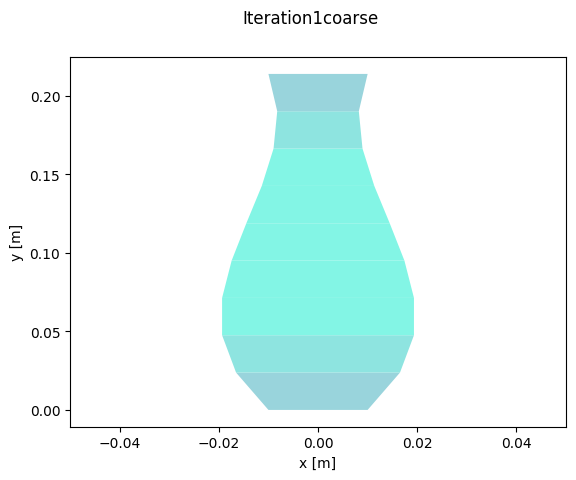

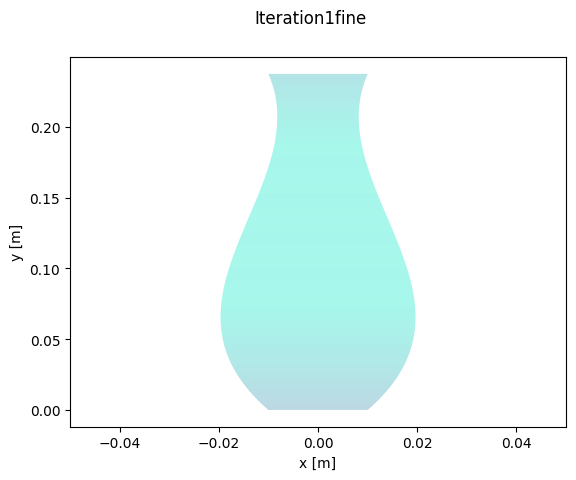

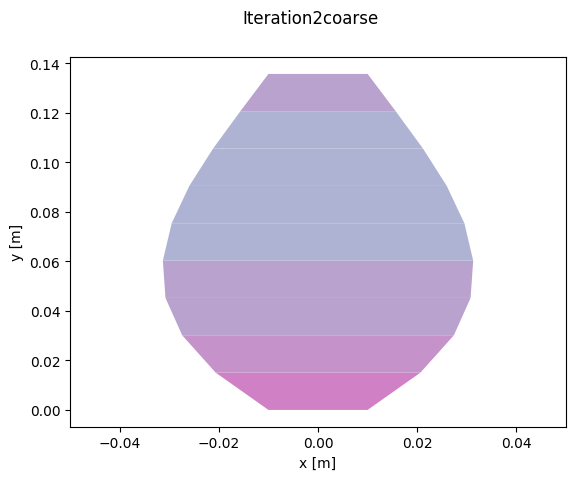

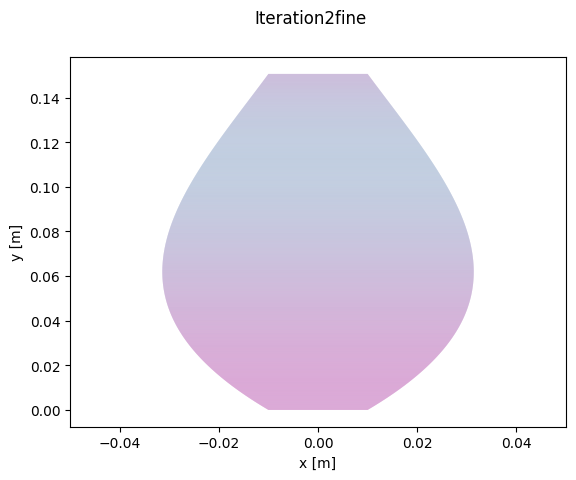

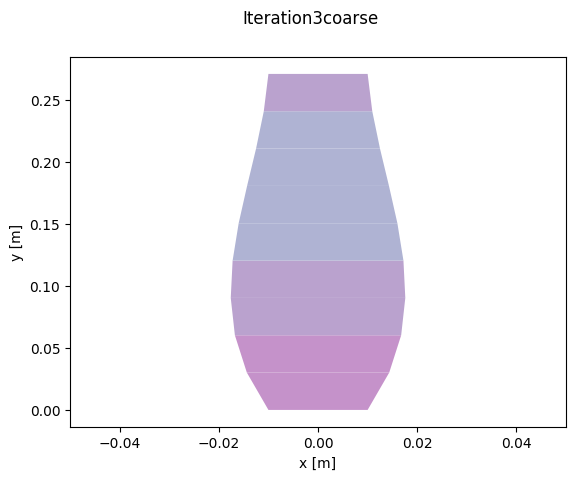

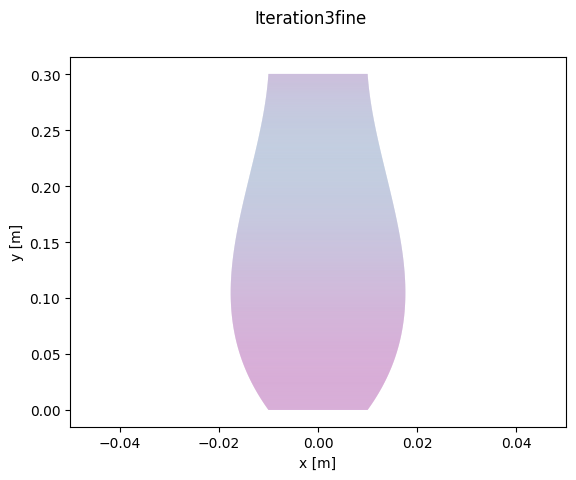

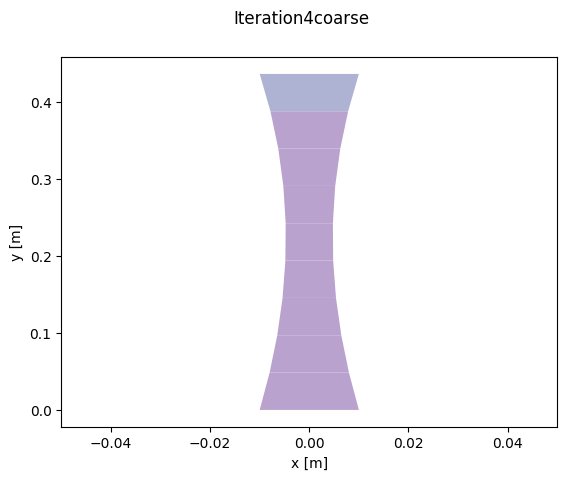

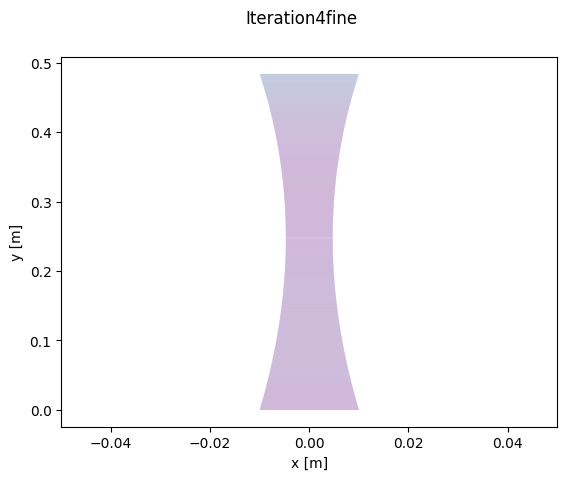

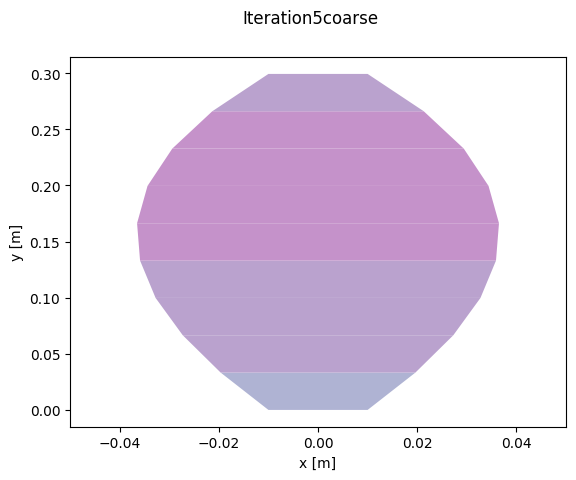

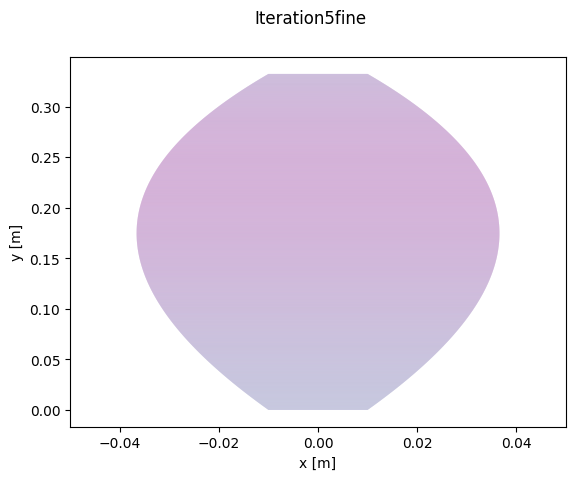

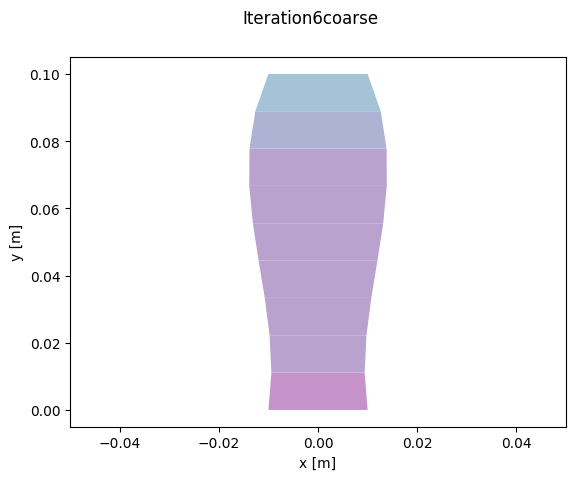

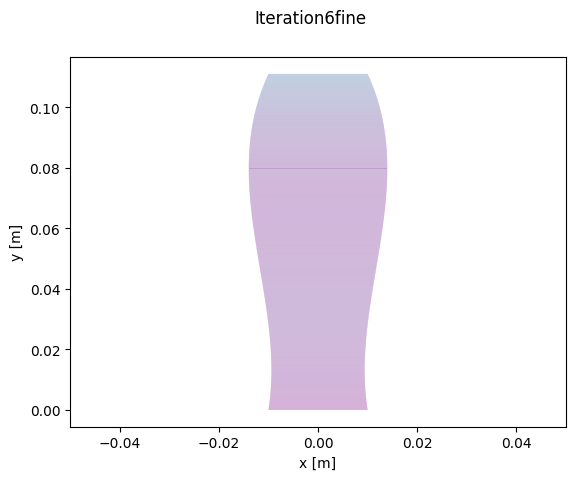

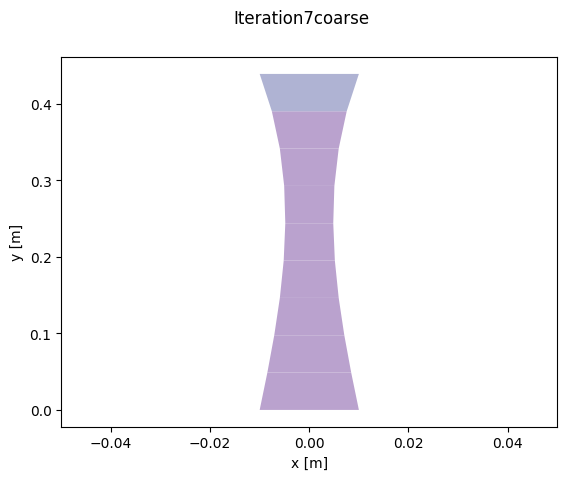

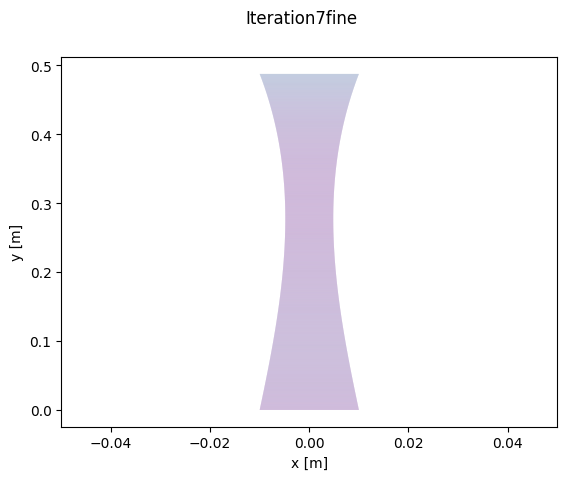

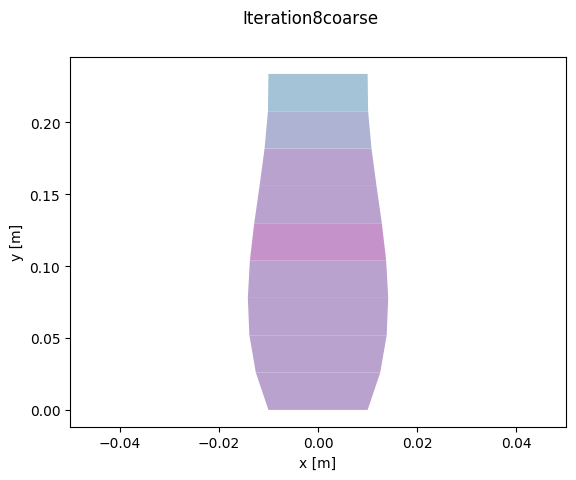

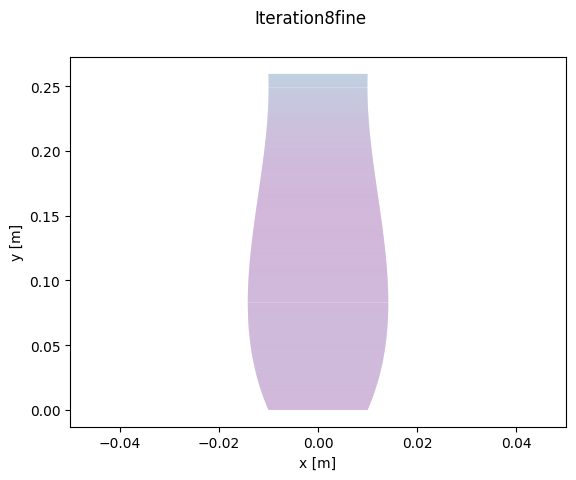

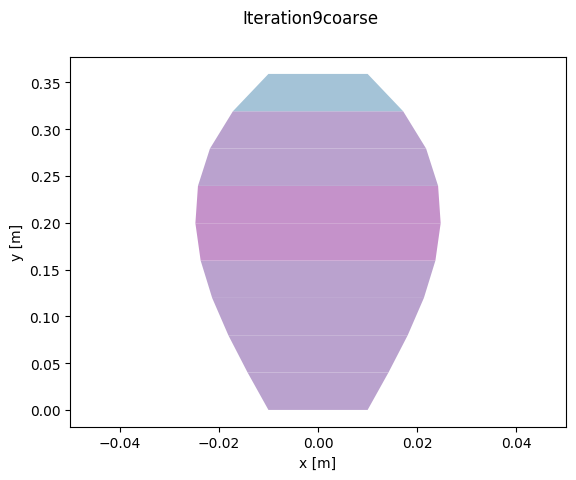

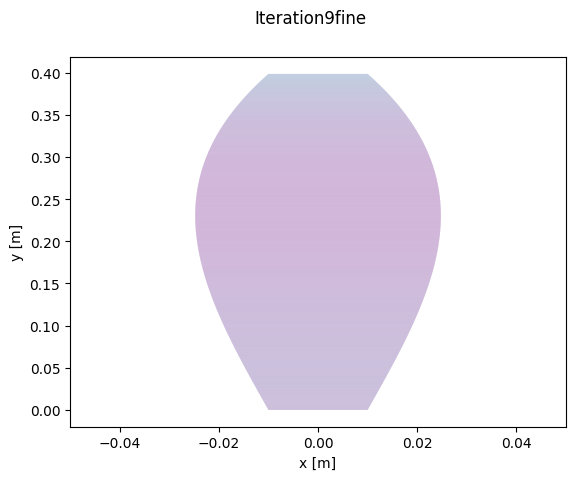

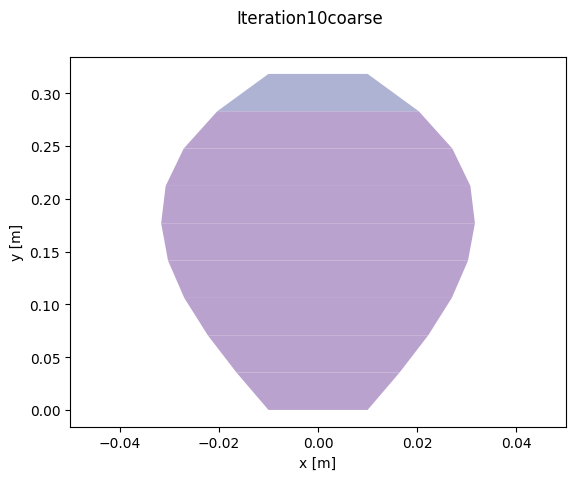

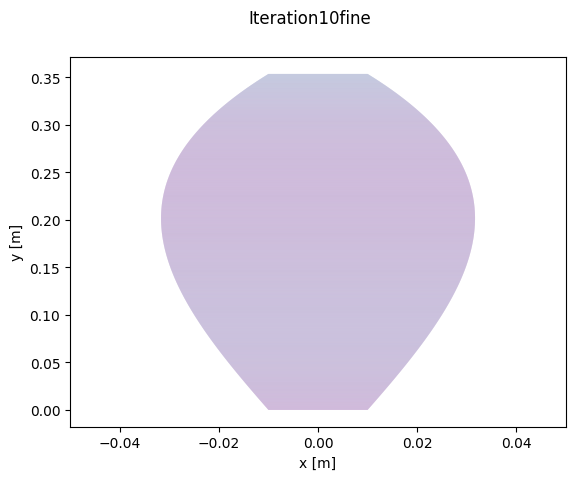

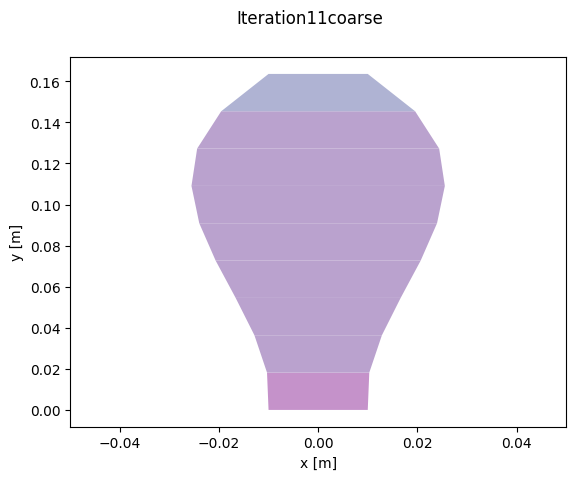

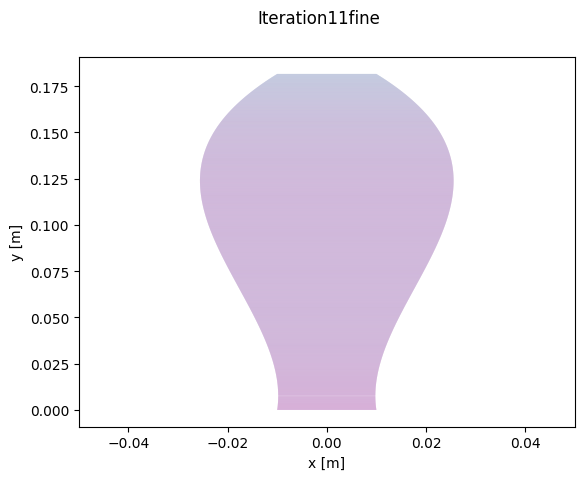

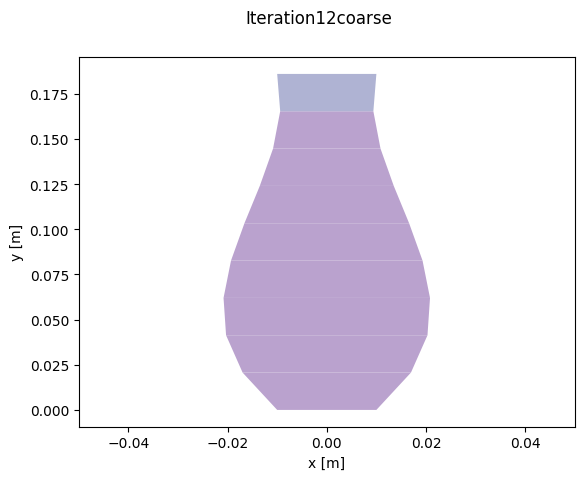

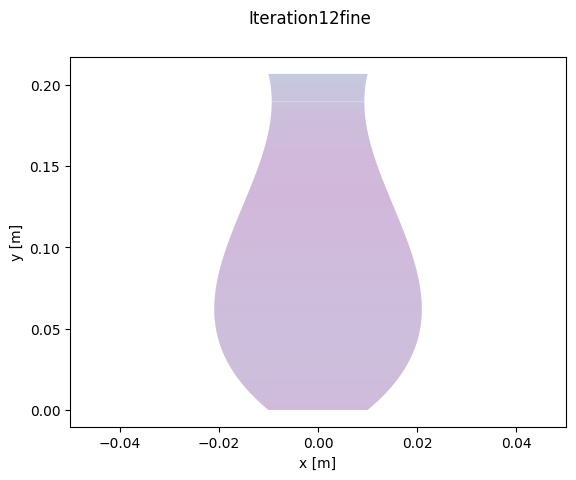

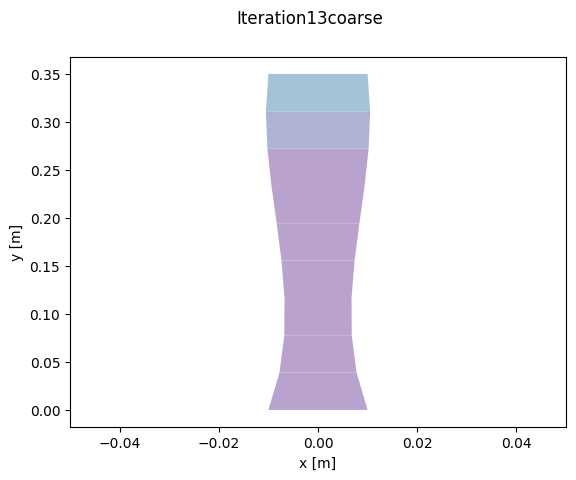

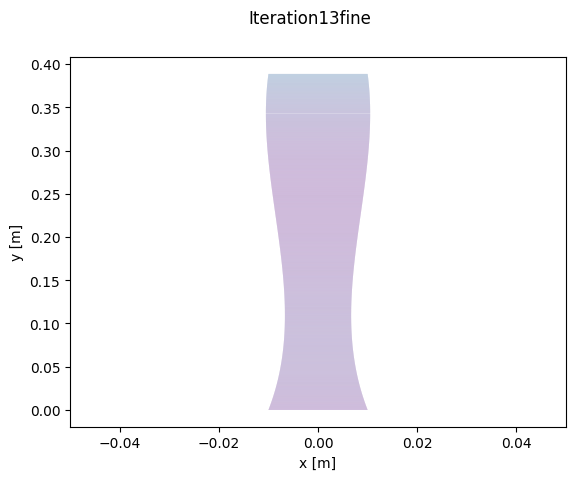

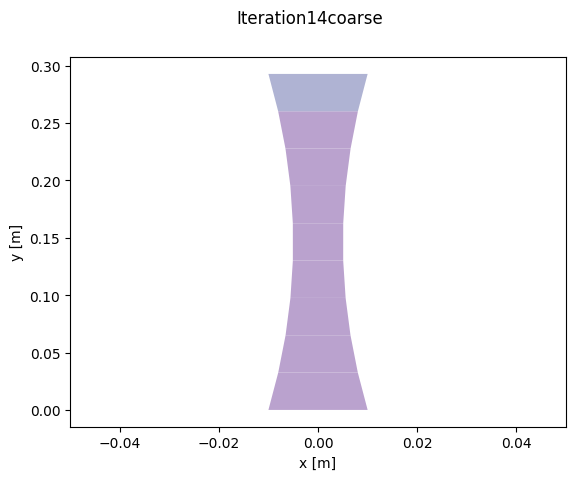

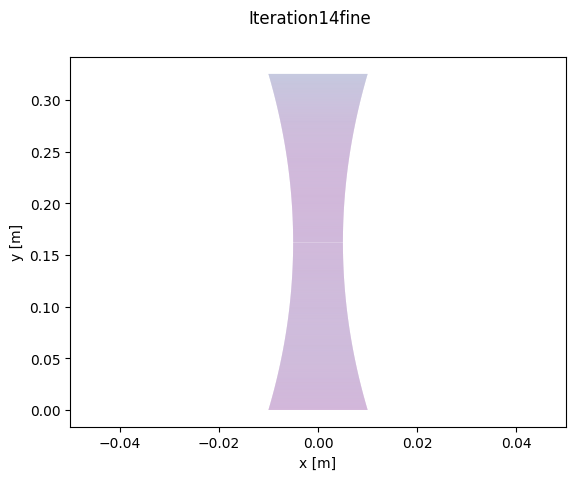

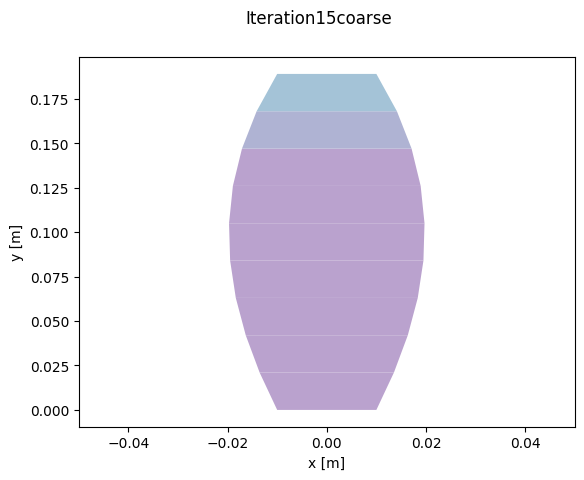

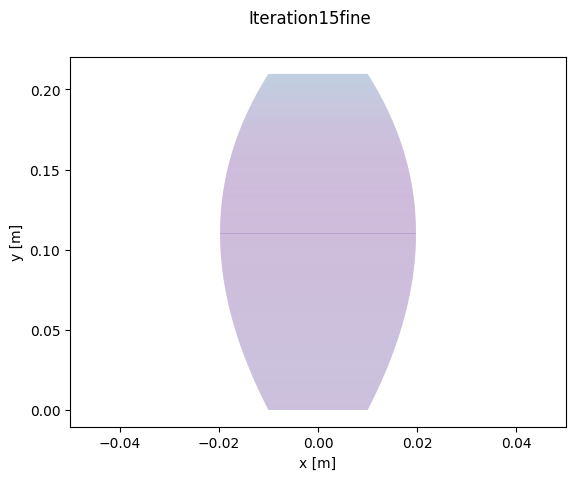

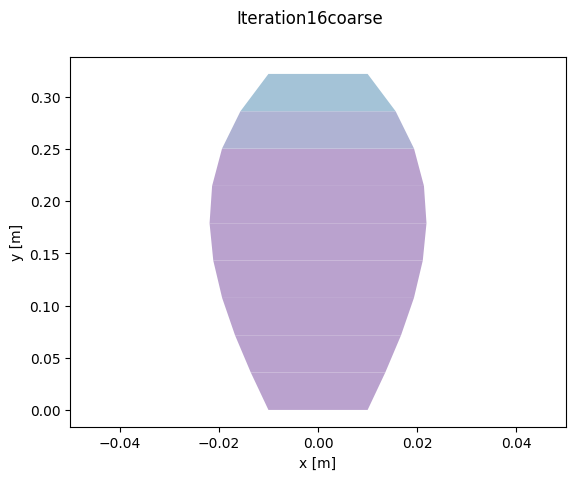

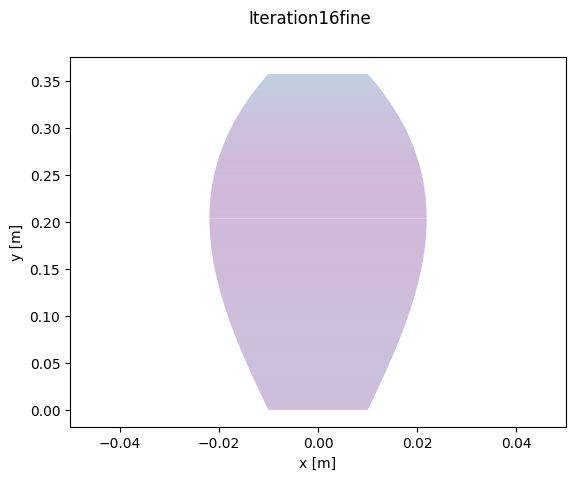

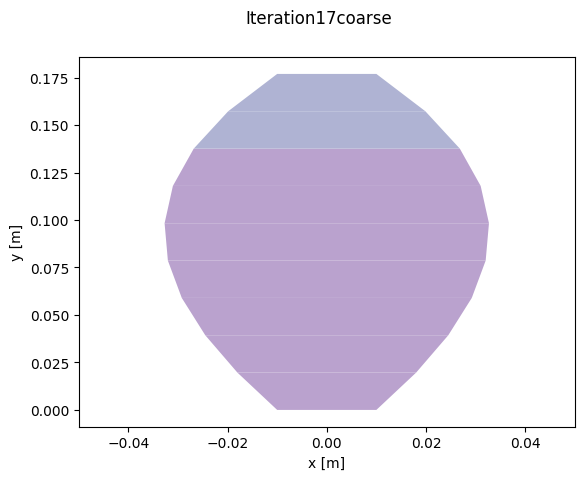

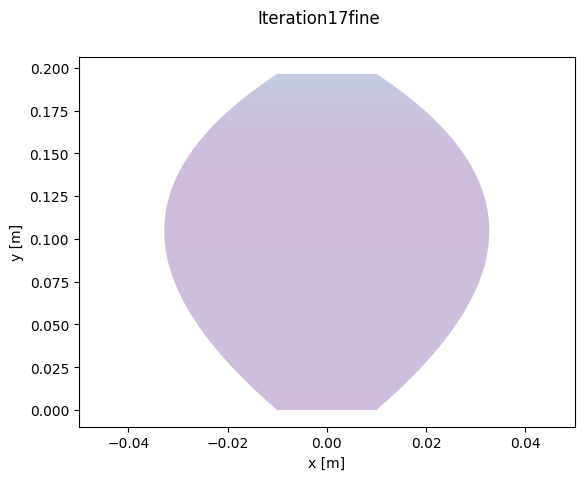

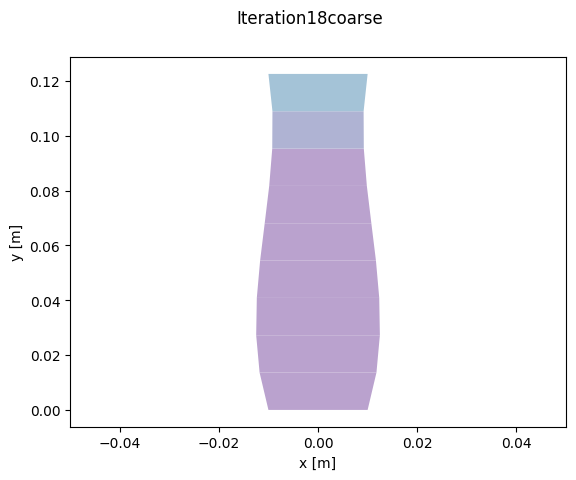

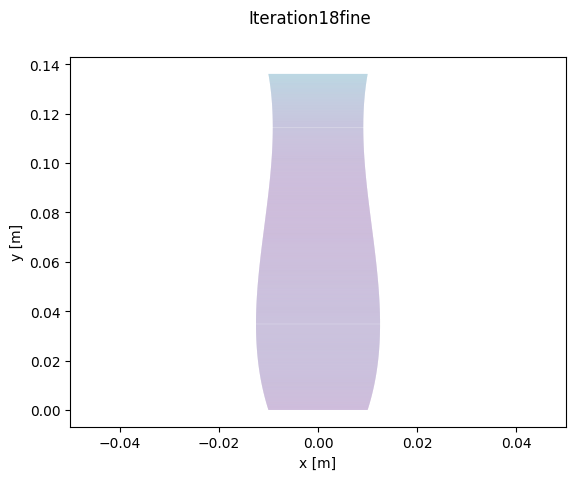

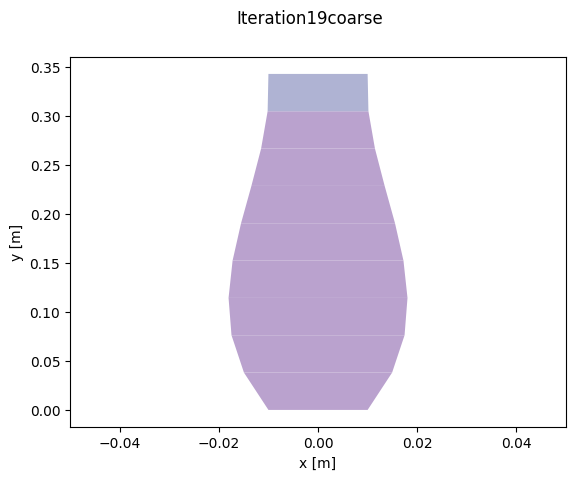

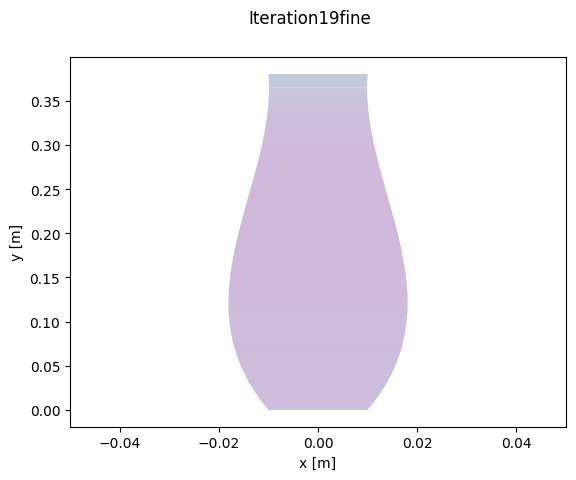

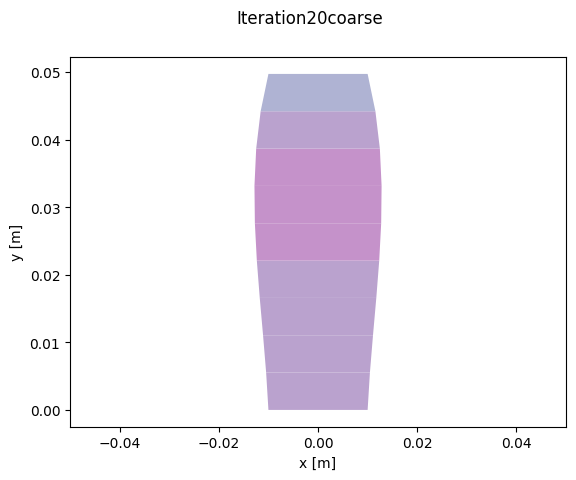

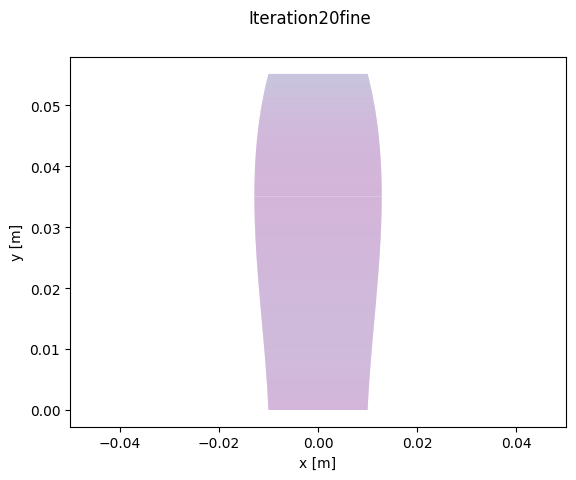

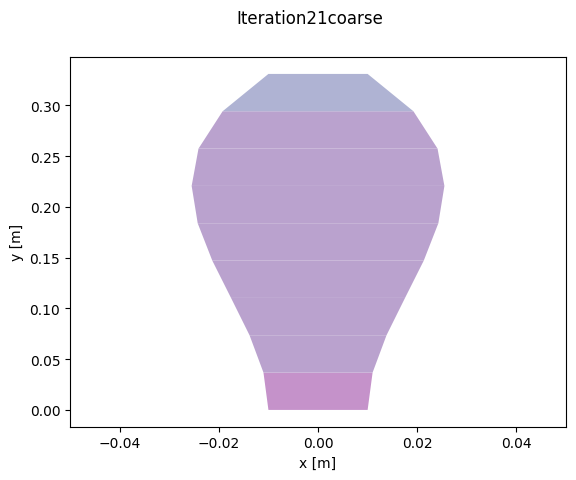

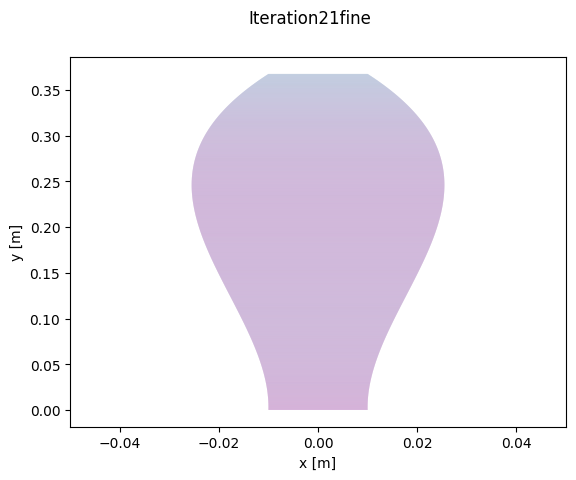

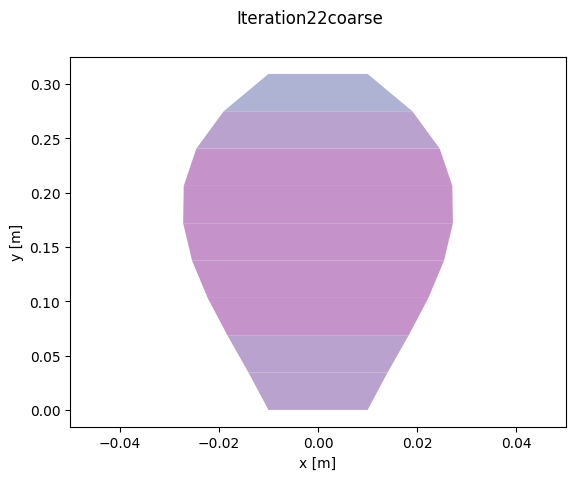

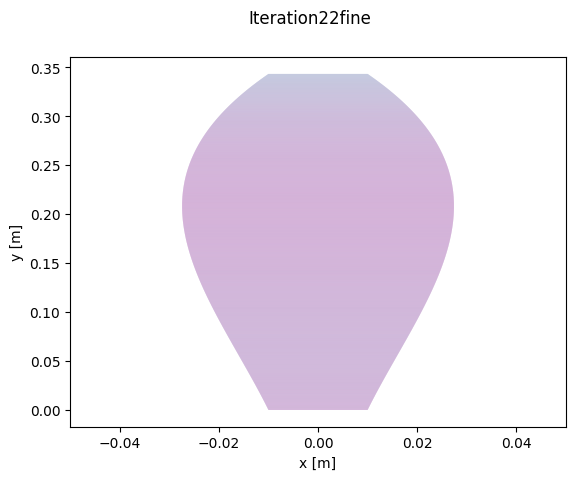

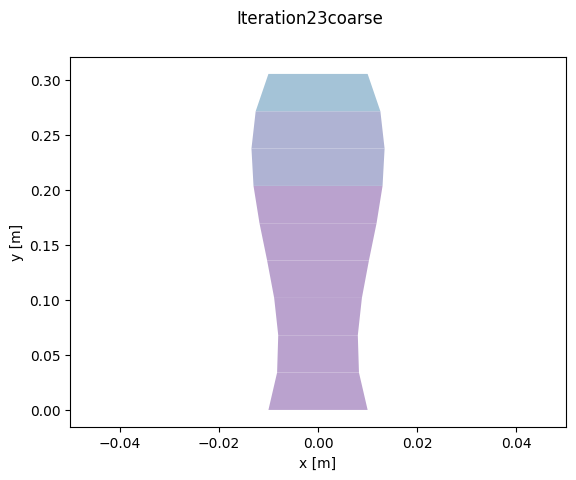

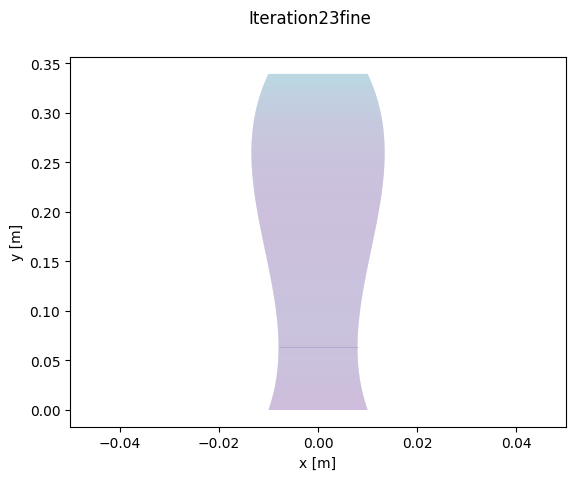

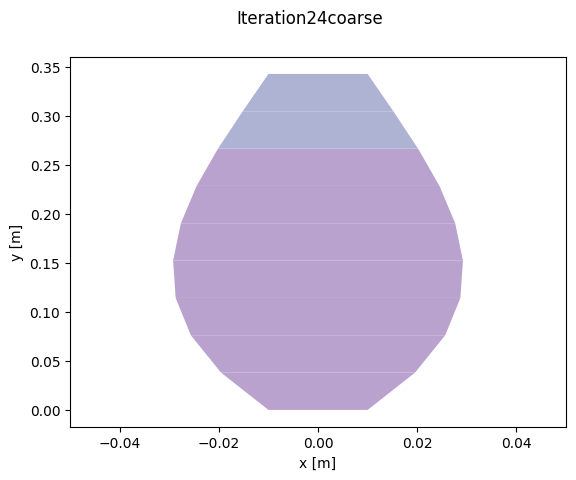

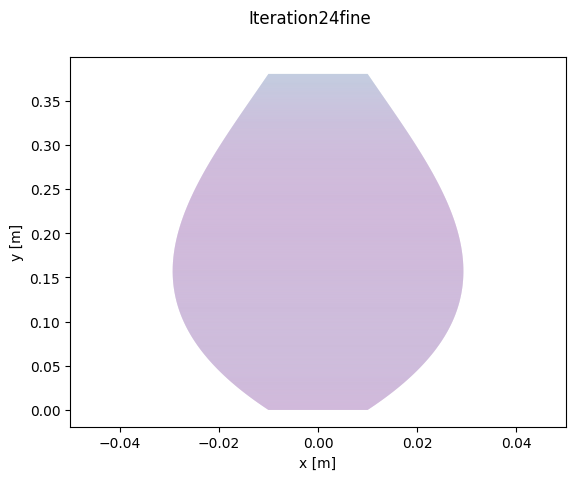

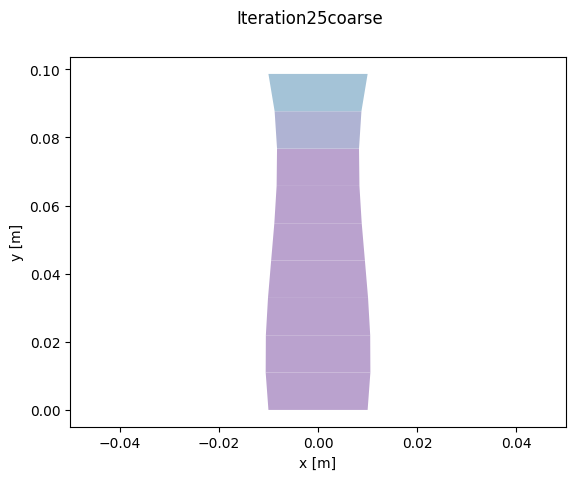

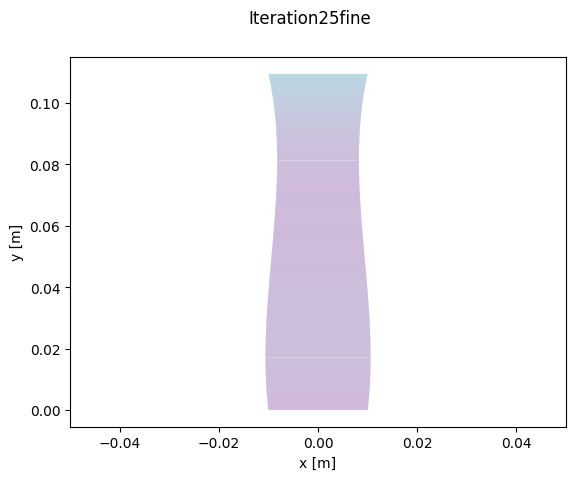

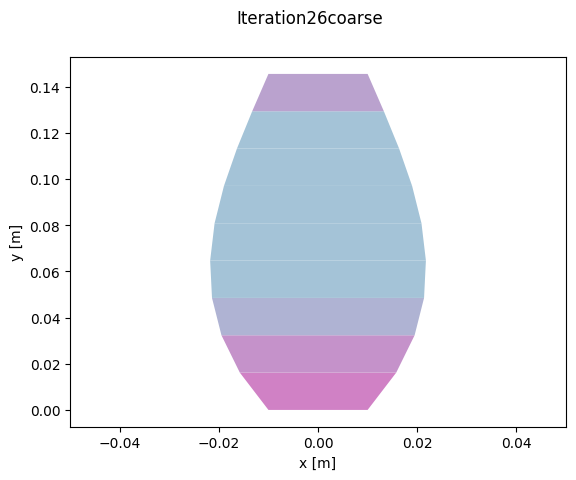

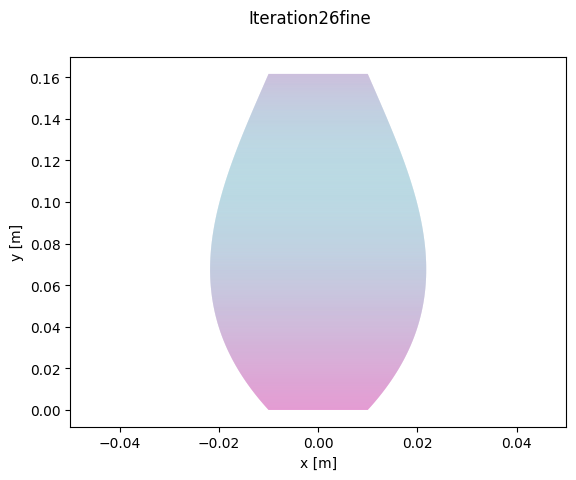

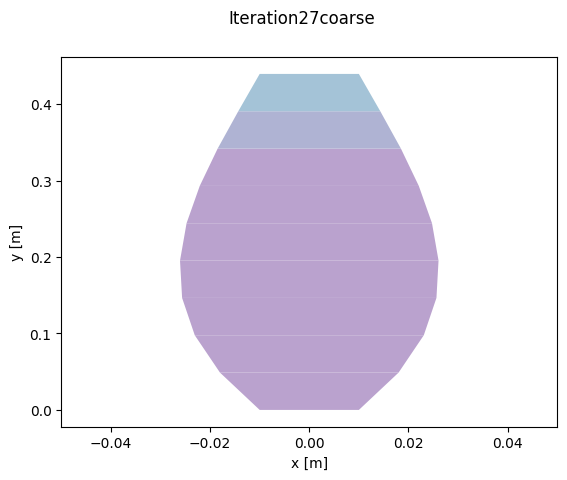

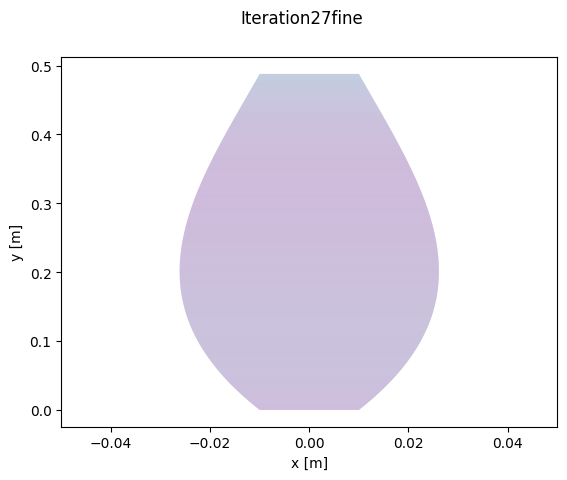

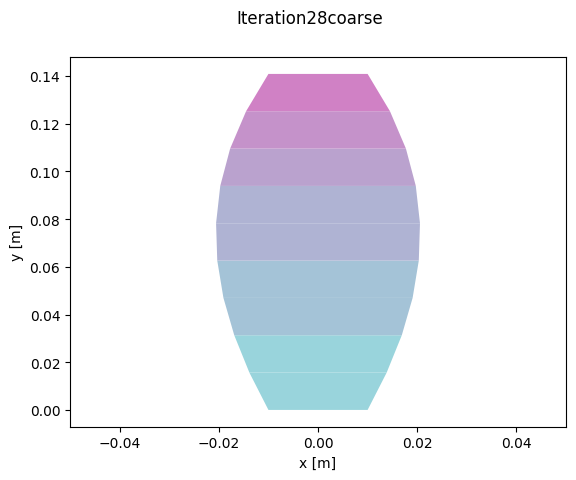

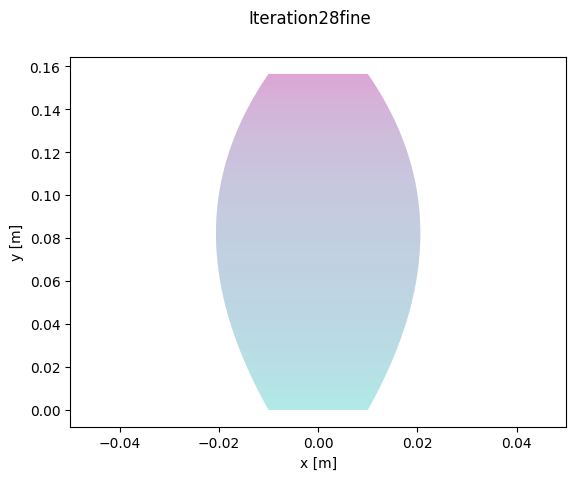

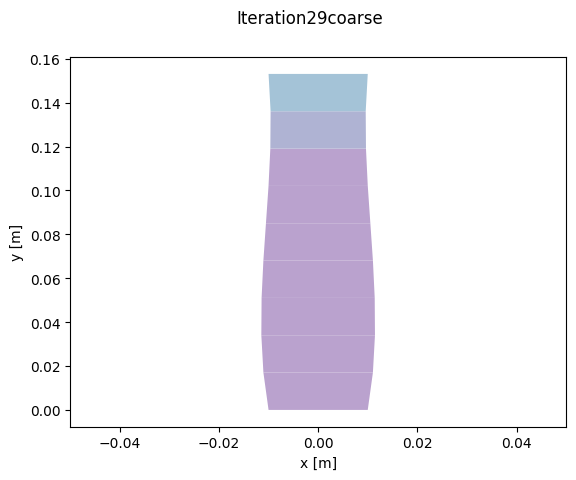

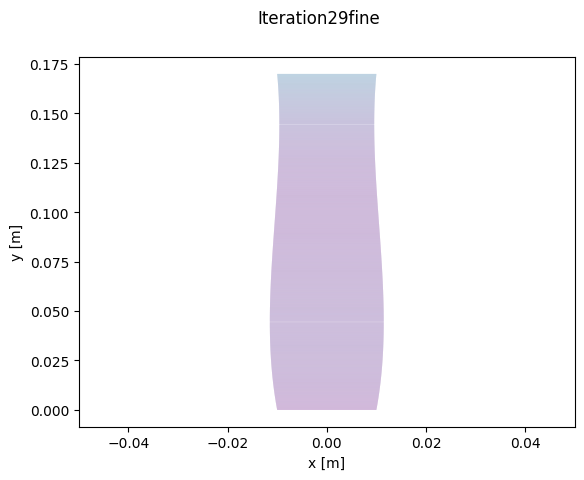

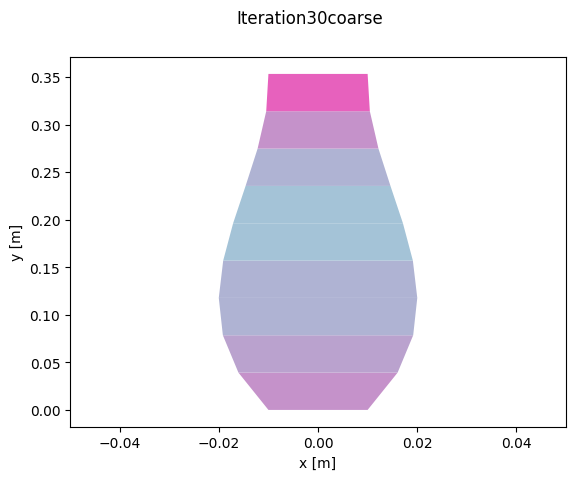

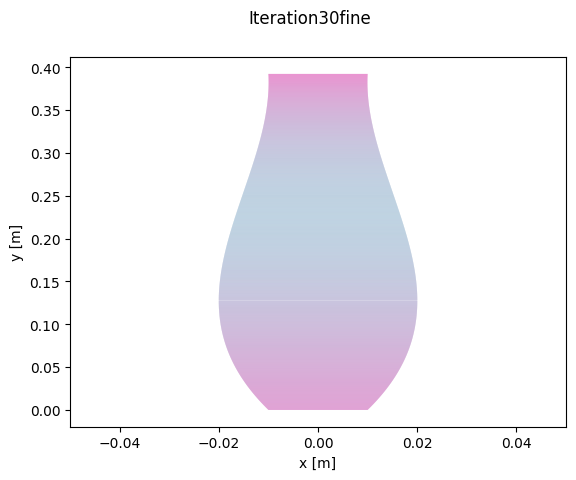

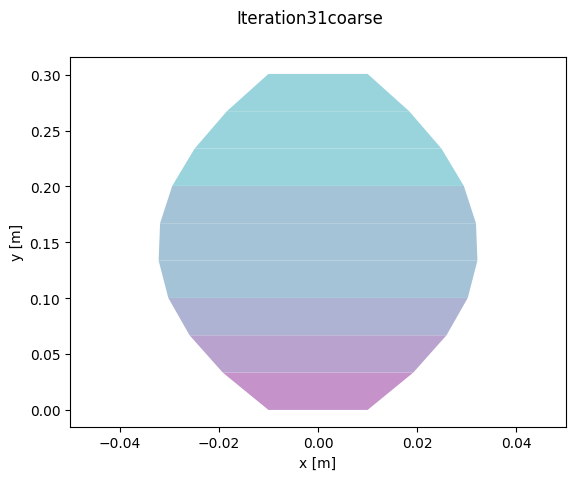

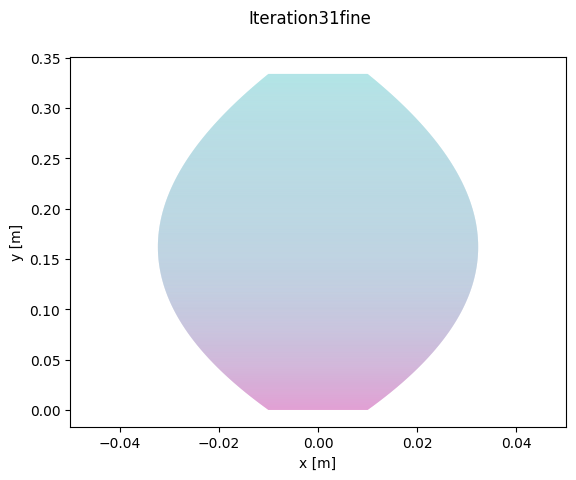

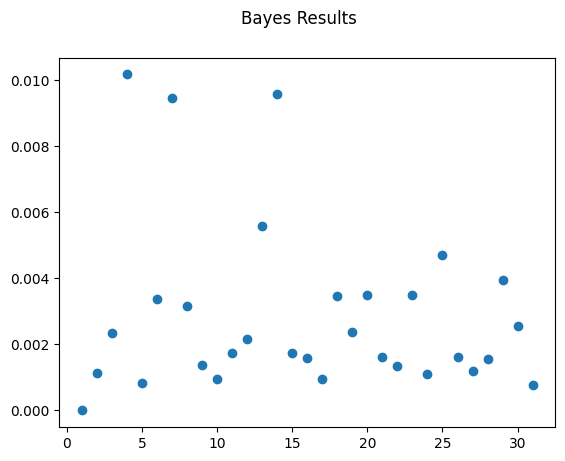

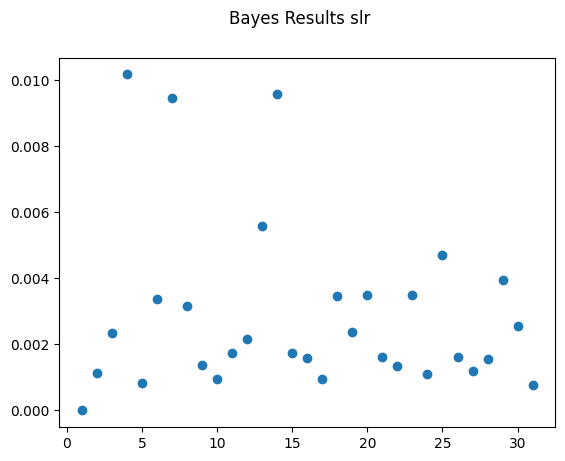

In [12]:
# Init

global n 
global count
global client 
global model
global s
global r

n = 10
r = 0.01 # Update for ability to sweep these in for loops
s = 40
its = 30

# To do
# [] Consistent sims for all
# [x] Basis model
# [] 


mode = "slr" # Set mode here
modes = ["slr", "r", "s", "sr"]
# opt
for mode in modes:
    print(mode)
    if mode == "sr":
        count = 1
        client = mph.start()
        client.clear()
        model = client.load('Bayes_Start.mph')
        out = Optimise_SR(its)
        score_plot(out)
    elif mode == "r":
        count = 1
        client = mph.start()
        client.clear()
        model = client.load('Bayes_Start.mph')
        out = Optimise_R(its)
        score_plot(out)
    elif mode == "s":
        count = 1
        client = mph.start()
        client.clear()
        model = client.load('Bayes_Start.mph')
        out = Optimise_S(its)
        score_plot(out)
    elif mode == "v":
        count = 1
        client = mph.start()
        client.clear()
        model = client.load('Bayes_Start.mph')
        
        out = Optimise_V(its)
        score_plot(out)
    elif mode == "3D":
        print("3D")
    elif mode == "slr":
        count = 1
        client = mph.start()
        client.clear()
        model = client.load('Bayes_Start.mph')
        out = Optimise_SLR(its)
        score_plot(out)
    fig, ax = plt.subplots()
    scores = np.zeros((31,1))
    for i in range(1,len(out)):
        scores[i] = out[i]['target']
    ax.scatter(np.linspace(1,31,31),scores)
    fig.suptitle('Bayes Results '+ mode)
    fig.savefig( 'Bayes Results' + mode + '.png')

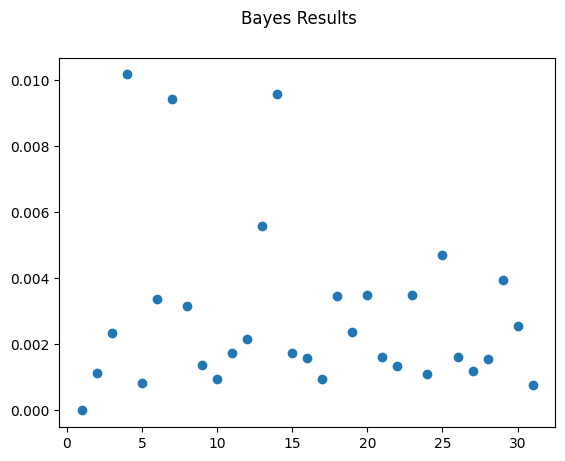

In [ ]:
fig, ax = plt.subplots()
scores = np.zeros((31,1))
for i in range(1,len(out)):
    scores[i] = out[i]['target']
ax.scatter(np.linspace(1,31,31),scores)
fig.suptitle('Bayes Results')
fig.savefig( 'Bayes Results.png')

In [ ]:
client.clear()

[1.48683889e-10 4.70150333e-07 8.65060312e-05 1.72652691e-03
 7.33538162e-03 9.49734800e-03 1.42117643e-02 2.20962764e-02
 2.61299258e-02 3.16290652e-02 3.86998814e-02 4.26179121e-02
 4.88965877e-02 6.05386733e-02 6.91113986e-02 7.92361312e-02
 8.58356510e-02 9.43098202e-02 1.09945256e-01 1.23703148e-01
 1.37010617e-01 1.47711486e-01 1.59812268e-01 1.70746807e-01
 1.82412388e-01 1.93850341e-01 1.95017184e-01]
[47.93999555 47.93995516 47.93978976 47.9393031  47.93812867 47.93731876
 47.93578721 47.93385501 47.93247193 47.9309037  47.92907553 47.92773969
 47.92601904 47.92278474 47.92015556 47.91748537 47.91541272 47.91308953
 47.90862133 47.90464127 47.90093593 47.89777221 47.8944216  47.89122579
 47.88793561 47.88467105 47.88437602]


NameError: name 'idx' is not defined

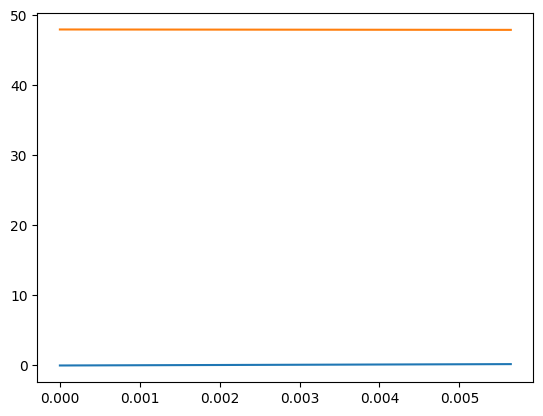

In [ ]:
data = pd.read_csv('results.csv')
data = data.to_numpy()
dataF = data[:,1]
datax = data[:,2]
time = data[:,0]
dataE = data[:,3]

Fph = 47.94*np.exp(-0.2057*(datax)) # Function pulled from Experimental fit
Fsee = -dataF
print(Fsee)
print(Fph)
fig, ax = plt.subplots()
ax.plot(datax,Fsee)
ax.plot(datax,Fph)
for i in range(np.size(datax)):
    if Fsee[i] >= Fph[i]:
        idx = i
        break 
    
print(idx)
